# ZFit Basic Example

First load the `zfit` and `numpy` libraries

In [1]:
import zfit
import numpy as np

/Users/maurizio/Software/zfit/lib/python3.10/site-packages/zfit/__init__.py:62: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


Create a variable `x` for the parameter space (observable), then create a model by declaring two parameters (`mu`,`sigma`) and a probability density function (`pdf.Gauss`).

Load the data as a `numpy` array and load it as a `zfit.Data` object.

Define a *loss* function (`UnbinnedNLL` in this example) and create the minimizer with an interface to `Minuit`. Calculate the results with the function `minimize` and the errors.

In [2]:
# observable
obs = zfit.Space('x', limits=(-10, 10))

# create the model
mu    = zfit.Parameter("mu"   , 2.4, -1, 5)
sigma = zfit.Parameter("sigma", 1.3,  0, 5)
gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma)

# load the data
data_np = np.random.normal(size=10000)
data = zfit.Data.from_numpy(obs=obs, array=data_np)

# build the loss
nll = zfit.loss.UnbinnedNLL(model=gauss, data=data)

# minimize
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)

# calculate errors
param_errors = result.hesse()

/Users/maurizio/Software/zfit/lib/python3.10/site-packages/zfit/minimizers/fitresult.py:1181: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_feature(message, "hesse_name")


In [3]:
param_errors

{<zfit.Parameter 'mu' floating=True value=0.004635>: {'error': 0.009896557482914105,
  'cl': 0.68268949},
 <zfit.Parameter 'sigma' floating=True value=0.9897>: {'error': 0.006997949927259121,
  'cl': 0.68268949}}

Print results

In [4]:
result

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sigma]] data=[<zfit.core.data.Data object at 0x15b6fa230>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 2.3e-07 │ -16601.06   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value  (rounded)        hesse    at limit
------  ------------------  -----------  ----------
mu              0.00463545  +/-  0.0099       False
sigma             0.989657  +/-   0.007       False

## Plotting
I suspect there is no plotting library for zfit (needs to investigate).
Let's make a simple plot here.

In [5]:
import mplhep
mplhep.style.use("LHCb2")
import matplotlib.pyplot as plt

In [6]:
# plotting options
n_sample = data_np.size
n_bins = 50
plot_scaling = n_sample / n_bins * obs.area()

In [7]:
print(n_sample, n_bins, obs.area(), plot_scaling / 2.5)

10000 50 tf.Tensor([20.], shape=(1,), dtype=float64) tf.Tensor([1600.], shape=(1,), dtype=float64)


Text(1, 0, 'obs: $x$')

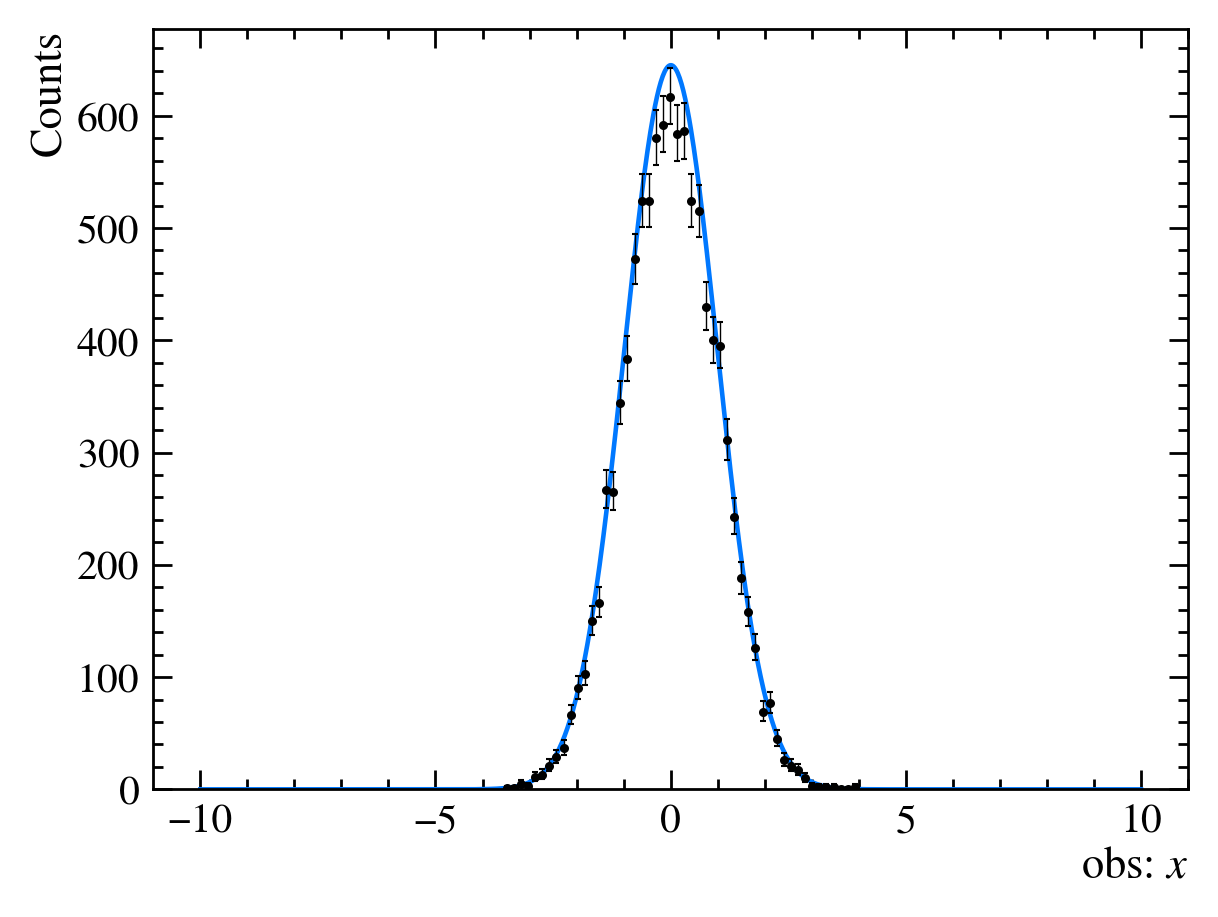

In [8]:
x = np.linspace(-10, 10, 1000)

plt.figure()
#plt.title(title)
y = gauss.pdf(x).numpy()
# y_gauss = (gauss.pdf(x) * frac).numpy()
# y_exp = (exponential.pdf(x) * (1 - frac)).numpy()
plt.plot(x, y * plot_scaling / 2.5, label="Sum - Model") # why 2.5???? see below
# plt.plot(x, y_gauss * plot_scaling, label="Gauss - Signal")
# plt.plot(x, y_exp * plot_scaling, label="Exp - Background")
mplhep.histplot(
    np.histogram(data_np, bins=n_bins),
    yerr=True,
    color="black",
    histtype="errorbar",
)
plt.ylabel("Counts")
plt.xlabel("obs: $x$")

## Plotter Class
The plot above was drawn with an integration mistake due to the calculation of the scaling factor accounting for the range of the *x* observable rather than the histogram range.
I solved the issue and created a plotting class that can be useful in general.

In [23]:
import os, sys
sys.path.append(f'{os.environ["PWD"]}/utilities')
from plotting import Plotter

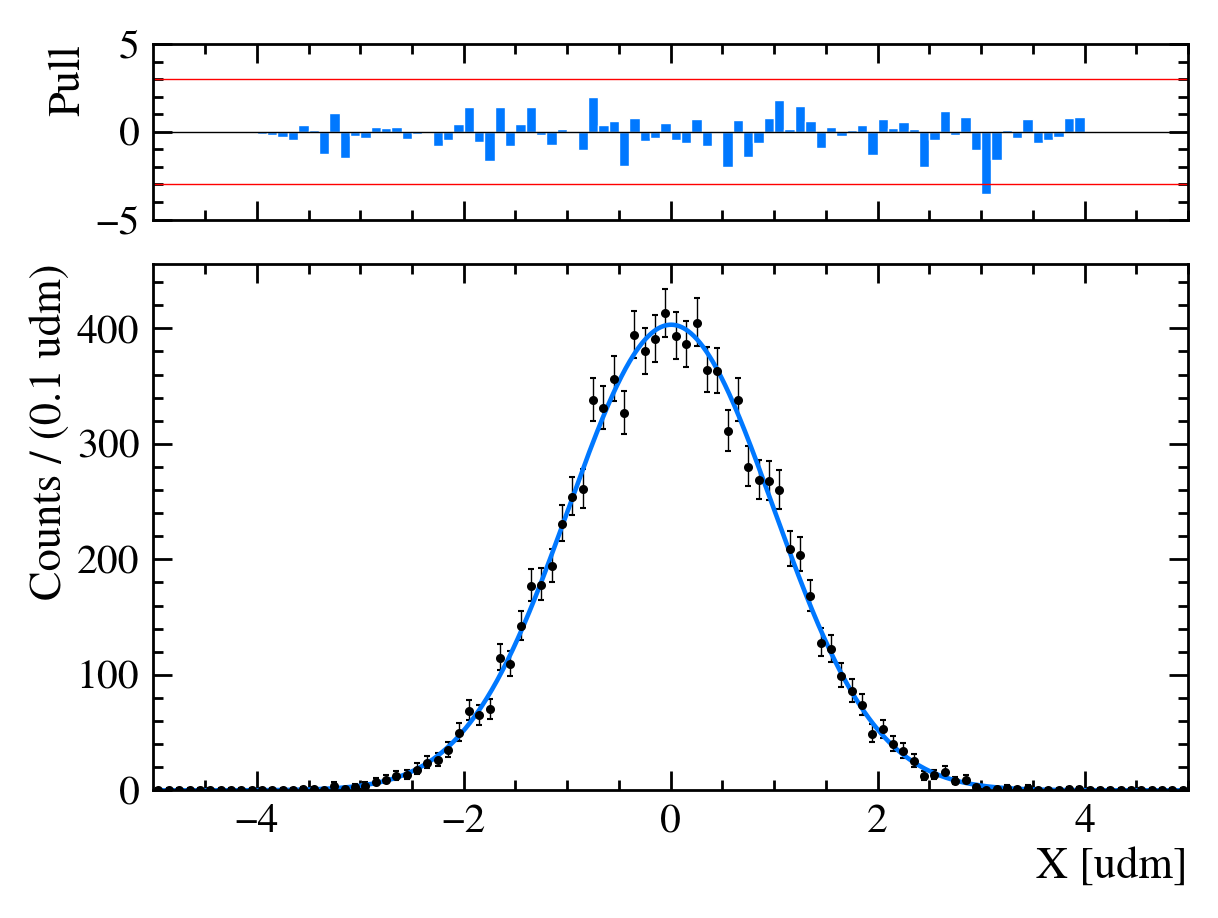

In [24]:
plotter = Plotter(data_np, gauss, bins=100, range=(-5,5), xlabel='X', xunit='udm')
fig, axs = plotter.plot_fit_and_residuals()

In [25]:
help(Plotter)

Help on class Plotter in module plotting:

class Plotter(builtins.object)
 |  Plotter(data, model, bins=100, range=None, xlabel=None, xunit=None)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data, model, bins=100, range=None, xlabel=None, xunit=None)
 |      A class to make fancy 1D plots of fits
 |      
 |      Args:
 |          data (array): an array of data
 |          model (zfit.pdf): the pdf of the model (zfit object)
 |          bins (int): the number of bins
 |          range (tuple): the range of the x axis
 |  
 |  plot_fit_and_residuals(self)
 |  
 |  pull_array(self, poisson=True)
 |      Calculate pulls of data and model
 |      
 |      Args:
 |          poisson (bool, optional): Use Poisson error for the counts. Defaults to True.
 |      
 |      Returns:
 |          tuple: the normalised pulls and the bin centers
 |  
 |  scale_factor(self, force=False)
 |      Calculate the scale factor for the model
 |      
 |      Returns:
 |          float: the scale fac